# Introduction to Machine Learning - project
## Stanford Car Body Type Classification

https://www.kaggle.com/datasets/mayurmahurkar/stanford-car-body-type-data - dataset

Import necessary libraries and moduels

In [1]:
import cv2
import os
import re
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from collections import Counter
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import precision_score, recall_score, f1_score,confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.utils import to_categorical

Definition of every funtions used in project

In [2]:
modelsDir = 'NeuralNetwork'
dataDir = 'data'
def plotPrint(history):

    epochs = np.arange(len(history.history['val_loss'])) + 1
    fig = plt.figure(figsize=(8, 4))
    if 'accuracy' in history.history:
        ax1 = fig.add_subplot(121)
        ax1.plot(epochs, history.history['loss'], c='b', label='Train loss')
        ax1.plot(epochs, history.history['val_loss'], c='g', label='Valid loss')
        plt.legend(loc='lower left');
        plt.grid(True)

        ax1 = fig.add_subplot(122)
        ax1.plot(epochs, history.history['accuracy'], c='b', label='Train acc')
        ax1.plot(epochs, history.history['val_accuracy'], c='g', label='Valid acc')
        plt.legend(loc='lower right');
        plt.grid(True)


    else:
        ax1 = fig.add_subplot(111)
        ax1.plot(epochs, history.history['loss'], c='b', label='Train loss')
        ax1.plot(epochs, history.history['val_loss'], c='g', label='Valid loss')
        plt.legend(loc='lower left');
        plt.grid(True)
    plt.show()

# def loadModel(c):
#     print("loadModel")
#     f = open(f"{modelsDir}/last.txt", "r")
#     name = f.readline()
#     print(f'model name: {name}')
#     f.close()
#     model = load_model(f'{modelsDir}/{name}/model.h5')
#     options = ['l', 't', 'q']
#     print(f"{options[0]} - loadWeights\n"
#           f"{options[1]} - trainModel\n"
#           f"{options[2]} - guit\n")
#     x = getInput(options,c)
#     if x == options[0]:
#         model.load_weights(f'{modelsDir}/{name}/weights.h5')
#     elif x == options[2]:
#         exit(0)
#     return model

# def saveModel(model):
#     dir = f'{modelsDir}'
#     if not os.path.exists(dir):
#         os.makedirs(dir)
#     name = runDataTime.strftime("%Y-%m-%d_%H_%M")
#     print(f'Save model: {name}')
#     model.save(f'{modelsDir}/{name}/model.h5')
#     model.save_weights(f'{modelsDir}/{name}/weights.h5')
#     f = open(f'{modelsDir}/last.txt', "w")
#     f.write(name)
#     f.close()

def saveModel(model, model_name):
    dir = f'{modelsDir}/{model_name}'
    if not os.path.exists(dir):
        os.makedirs(dir)
    model.save(f'{modelsDir}/{model_name}/model.h5')
    print(f"Model został zapisany pod nazwą: {model_name}")

def loadModel(model_name):
    loaded_model = tf.keras.models.load_model(f'{modelsDir}/{model_name}/model.h5')
    print(f"Model został wczytany z pliku: {model_name}")
    return loaded_model

def loadImage(imageDir, new=True):
    if (new): 
        csv_file = f'{dataDir}/new_stanford_cars_type.csv'
    else:
        csv_file = f'{dataDir}/stanford_cars_type.csv'

    img_folder = f'{dataDir}/{imageDir}'
    data_csv = pd.read_csv(csv_file)
    images_tab = []
    labels_string = []

    for index, row in data_csv.iterrows():
        filename = row['file_name']
        category = row['car_type']

        image_path = os.path.join(img_folder, filename)

        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        images_tab.append(image)
        labels_string.append(category)
    images = np.array(images_tab)
    return (images,labels_string)

def encodeLabel(labels_s):
    label_encoder = LabelEncoder()
    labels_encoded = label_encoder.fit_transform(labels_s)
    return (labels_encoded, label_encoder)


def preprocessImages(images):
    preprocessed_images = []
    for image in images:
        equalized_image = cv2.equalizeHist(np.uint8(image))
        normalized_image = equalized_image / 255.0
        preprocessed_images.append(normalized_image)
    preprocessed_images = np.array(preprocessed_images)
    return preprocessed_images

def resizeAndSaveImages(input_folder, output_folder, target_size=(255, 255)):
    output_folder = f'{dataDir}/{output_folder}'
    input_folder = f'{dataDir}/{input_folder}'
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    for filename in os.listdir(input_folder):
        if filename.endswith('.jpg'):
            image_path = os.path.join(input_folder, filename)
            image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
            resized_image = cv2.resize(image, target_size)
            output_path = os.path.join(output_folder, filename)
            cv2.imwrite(output_path, resized_image)


def generateFromOriginalImages(outputFlder, newSize=(256,256)):
    main_data_folder = f'{dataDir}/stanford_cars_type'

    output_folder = f'{dataDir}/{outputFlder}'
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    for label in os.listdir(main_data_folder):
        label_folder = os.path.join(main_data_folder, label)
        
        for image_file in os.listdir(label_folder):
            image_path = os.path.join(label_folder, image_file)

            # Wyodrębnij tylko cyfry z początku nazwy
            numeric_prefix = re.match(r'^\d+', image_file).group()

            # Wczytaj obraz za pomocą OpenCV
            image = cv2.imread(image_path)

            # Przeskaluj obraz do nowego wymiaru (255x255) i zamień na skalę szarości
            image = cv2.resize(image, newSize)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

            # Nazwa nowego pliku
            new_filename = f'{numeric_prefix}.jpg'
            new_image_path = os.path.join(output_folder, new_filename)

            # Zapisz przetworzony obraz
            cv2.imwrite(new_image_path, image)
            
def splitData(images,labels_encoded):
    imagesData = images.reshape(images.shape + (1,))
    X_train, X_test, y_train, y_test = train_test_split(imagesData, labels_encoded, test_size=0.2, random_state=1, stratify=labels_encoded)
    return (X_train, X_test, y_train, y_test)



def labelsPlot(labels_string):
    # Zliczenie etykiet
    label_counts = Counter(labels_string)

    print(label_counts)

    # Rozpakowanie nazw etykiet i ich liczności do wykresu słupkowego
    labels, counts = zip(*label_counts.items())

    # Generowanie wykresu słupkowego
    plt.figure(figsize=(8, 6))
    plt.bar(labels, counts, color='skyblue')
    plt.xlabel('Klasy etykiet')
    plt.ylabel('Liczba obrazów')
    plt.title('Rozkład klas etykiet')
    plt.xticks(rotation=45)
    plt.tight_layout()

    plt.show()






# def generate_image_histogram_by_index(images_data, labels, index, bins=256):
#     # Sprawdzenie poprawności indeksu
#     if index < 0 or index >= len(images_data):
#         print("Nieprawidłowy indeks")
#         return

#     print("images len = ", len(images_data))

#     # Wybranie obrazu na podstawie indeksu
#     image = images_data[index].reshape(255,255)
  
#     # Wyświetlenie obrazu i jego histogramu
#     plt.figure(figsize=(8, 4))

#     plt.subplot(1, 2, 1)
#     plt.imshow(image, cmap='gray')
#     plt.title(f'Wybrane zdjęcie: {index}')
#     plt.axis('off')

#     plt.subplot(1, 2, 2)
#     plt.hist(image.ravel(),100,[0,255])
#     plt.title('Histogram wybranego zdjęcia')
#     plt.xlabel('Wartość piksela')
#     plt.ylabel('Liczba pikseli')
#     plt.grid()

#     plt.tight_layout()
#     plt.show()

def generate_image_histogram_by_index(images_data, labels, index, bins=256):
    # Sprawdzenie poprawności indeksu
    if index < 0 or index >= len(images_data):
        print("Nieprawidłowy indeks")
        return
    image = images_data[index]
    max_value = np.max(image)
    if not(max_value > 1):
        image = image * 255.0
    height, width = image.shape[:2]

    plt.figure(figsize=(8, 4))

    plt.subplot(1, 3, 1)
    plt.imshow(image, cmap='gray')
    plt.title(f'Wybrane zdjęcie: {index}\nRozmiar: {width}x{height}')
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.hist(image.ravel(), bins, [0, 255])
    plt.title(f'Histogram wybranego zdjęcia {labels[index]}')
    plt.xlabel('Wartość piksela')
    plt.ylabel('Liczba pikseli')
    plt.grid()


    plt.tight_layout()
    plt.show()

def showImage(index):
    plt.imshow(images[index], cmap='gray')  # 'gray' oznacza, że obraz będzie wyświetlony w skali szarości
    plt.axis('off')  # Wyłączenie osi
    plt.title(f"Obraz {index}")
    plt.show()

def save_dataframe_to_csv(df, file_path):
    df.to_csv(file_path, index=False)

def read_dataframe_from_csv(file_path):
    return pd.read_csv(file_path)


Counter({'Sedan': 1907, 'Van': 1513, 'SUV': 1437, 'Coupe': 1088, 'Convertible': 1036})


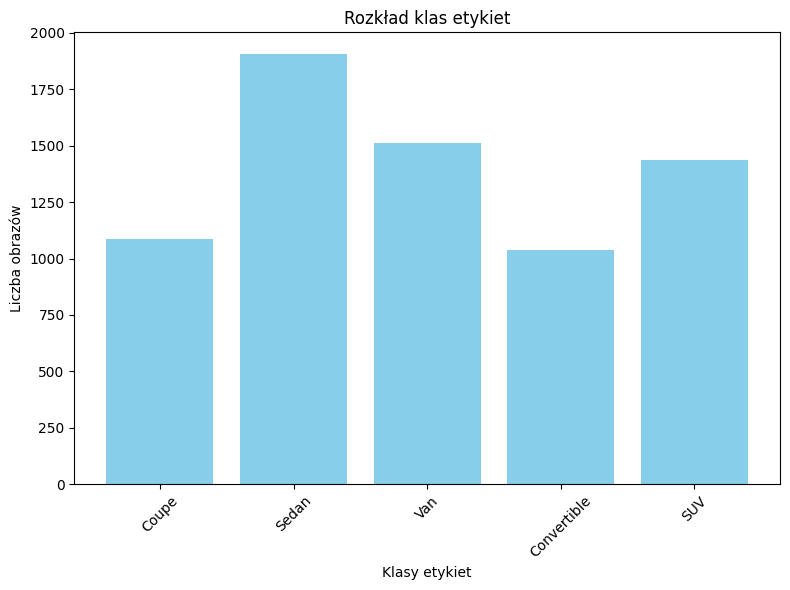

(6981,)
(6981, 128, 128)


In [3]:
images, labels = loadImage('128x128')
labelsPlot(labels)
labels_encoded, labels_encoder = encodeLabel(labels)
print(labels_encoded.shape)
print(images.shape)
imagesProc = preprocessImages(images)
# X_train, X_test, y_train, y_test = splitData(imagesProc,labels_encoded)

### Eksploracyjna analiza danych
Przed wygenerowaniem wykresu należy uruchomić poprzednią komórkę, która zawiera przetworzone obrazy
- Wykres przedstawiający rozkład klas etykiet
- Możliwość wyświetlenia dowolnego obrazu ze zbioru danych wraz z histogramem

   Unnamed: 0  file_name  car_code                             car_name  \
0           0  00001.jpg        14                  Audi TTS Coupe 2012   
1           1  00002.jpg         3                  Acura TL Sedan 2012   
2           2  00003.jpg        91           Dodge Dakota Club Cab 2007   
3           3  00004.jpg       134     Hyundai Sonata Hybrid Sedan 2012   
4           4  00005.jpg       106  Ford F-450 Super Duty Crew Cab 2012   

     brand car_type                                   new_filename  
0     Audi    Coupe                  00001_Audi TTS Coupe 2012.jpg  
1    Acura    Sedan                  00002_Acura TL Sedan 2012.jpg  
2    Dodge      Cab           00003_Dodge Dakota Club Cab 2007.jpg  
3  Hyundai    Sedan     00004_Hyundai Sonata Hybrid Sedan 2012.jpg  
4     Ford      Cab  00005_Ford F-450 Super Duty Crew Cab 2012.jpg  
Counter({'Sedan': 1907, 'SUV': 1437, 'Coupe': 1088, 'Convertible': 1036, 'Cab': 719, 'Other': 609, 'Hatchback': 554, 'Wagon': 291, 'Van

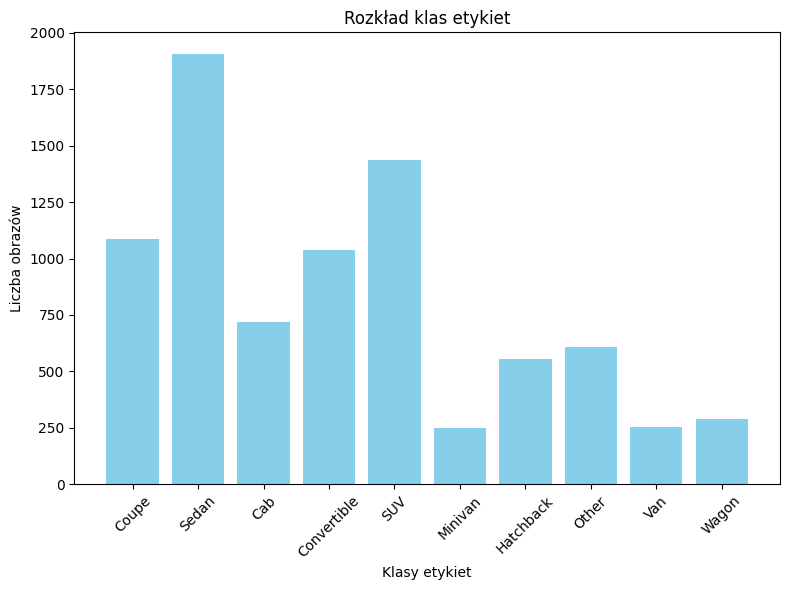

Counter({'Sedan': 1907, 'Van': 1513, 'SUV': 1437, 'Coupe': 1088, 'Convertible': 1036})


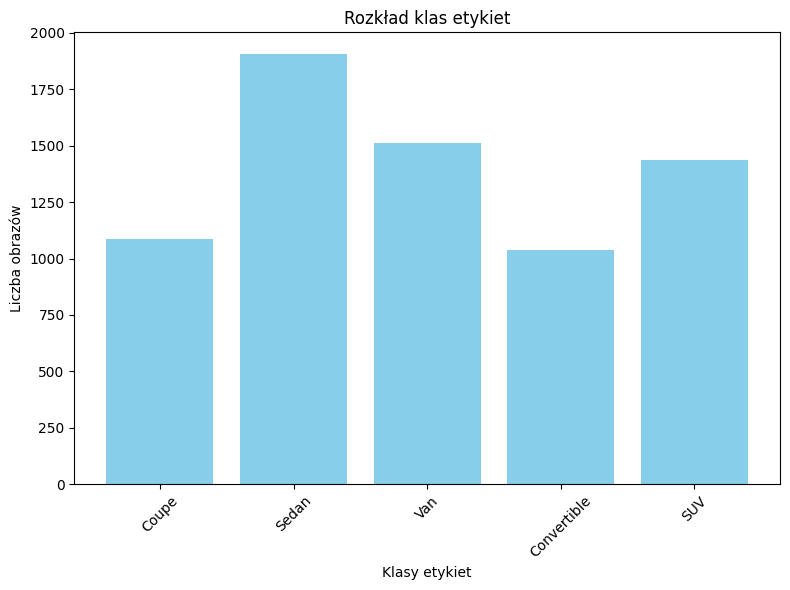

In [ ]:
csv_file = 'data/stanford_cars_type.csv'
data_csv = pd.read_csv(csv_file)
print(data_csv.head())
labelsPlot(data_csv['car_type'])
data_csv['car_type'].replace('Minivan', 'Van', inplace=True)

data_csv['car_type'].replace('Wagon', 'Van', inplace=True)

data_csv['car_type'].replace('Cab', 'Van', inplace=True)

data_csv = data_csv[~data_csv['car_type'].isin(['Other', 'Hatchback'])]

labelsPlot(data_csv['car_type'])

data_csv.to_csv('data/new_stanford_cars_type.csv', index=False)

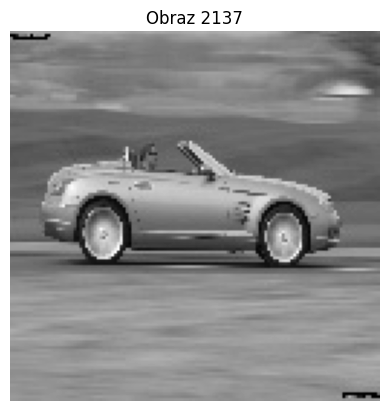

In [7]:
# Indeks obrazu do wyświetlenia
index_to_display = 2137  # Możesz zmienić indeks, aby wyświetlić inny obraz

# Wyświetlenie wybranego obrazu
plt.imshow(images[index_to_display], cmap='gray')  # 'gray' oznacza, że obraz będzie wyświetlony w skali szarości
plt.axis('off')  # Wyłączenie osi
plt.title(f"Obraz {index_to_display}")
plt.show()

#### Split dataset

In [24]:
X_train, X_test, y_train, y_test = train_test_split(imagesProc, labels_encoded, test_size=0.2, stratify=labels_encoded)
X_train = X_train.reshape(X_train.shape + (1,))
X_test = X_test.reshape(X_test.shape + (1,))

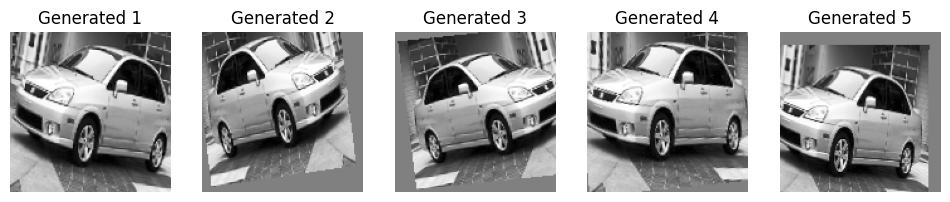

In [18]:
# resizeAndSaveImages('processed','64x64',(64,64))

# chosen_index = 345  # Indeks wybranego zdjęcia
# generate_image_histogram_by_index(images, labels, chosen_index)
# generate_image_histogram_by_index(imagesProc, labels, chosen_index)

datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='constant',
    cval=127
)


img = X_train[0]
img = np.expand_dims(img, axis=0)  # Dodanie dodatkowego wymiaru
img = img * 255.
flow = datagen.flow(img, batch_size=1)

# Generowanie kilku obrazów za pomocą ImageDataGenerator
generated_images = [next(flow)[0].astype(np.uint8).reshape(X_train[0].shape) for _ in range(5)] 

# Wyświetlenie wygenerowanych obrazów
plt.figure(figsize=(12, 6))
for i, img in enumerate(generated_images):
    plt.subplot(1, 5, i + 1)
    plt.imshow(img, cmap='gray')
    plt.title(f'Generated {i + 1}')
    plt.axis('off')

plt.show()

Epoch 1/5
204/204 [==============================] - 149s 724ms/step - loss: 3.2879 - accuracy: 0.2203 - val_loss: 2.0593 - val_accuracy: 0.2370
Epoch 2/5
204/204 [==============================] - 150s 734ms/step - loss: 1.6322 - accuracy: 0.4573 - val_loss: 2.0468 - val_accuracy: 0.2713
Epoch 3/5
204/204 [==============================] - 149s 733ms/step - loss: 0.8466 - accuracy: 0.7566 - val_loss: 2.2884 - val_accuracy: 0.2664
Epoch 4/5
204/204 [==============================] - 148s 725ms/step - loss: 0.2544 - accuracy: 0.9558 - val_loss: 2.7031 - val_accuracy: 0.2591
Epoch 5/5
204/204 [==============================] - 148s 725ms/step - loss: 0.0717 - accuracy: 0.9954 - val_loss: 3.1928 - val_accuracy: 0.2345


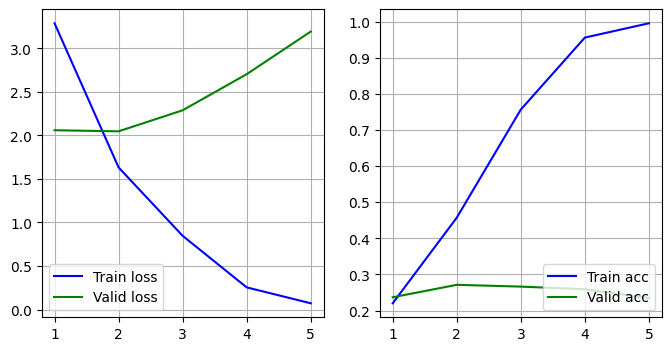

51/51 - 5s - loss: 3.1928 - accuracy: 0.2345 - 5s/epoch - 103ms/step

Test accuracy: 0.23449969291687012


In [9]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(255, 255, 1)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(len(labels_encoder.classes_), activation='softmax')
])

# Skompiluj model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Wytrenuj model
history = model.fit(X_train, y_train, epochs=5, validation_data=(X_test, y_test))

plotPrint(history)

# Ocena modelu na danych testowych
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
print(f'\nTest accuracy: {test_acc}')

Epoch 1/5
175/175 [==============================] - 20s 113ms/step - loss: 1.5840 - accuracy: 0.2684 - val_loss: 1.5635 - val_accuracy: 0.2706
Epoch 2/5
175/175 [==============================] - 19s 111ms/step - loss: 1.5306 - accuracy: 0.3044 - val_loss: 1.5642 - val_accuracy: 0.3142
Epoch 3/5
175/175 [==============================] - 20s 114ms/step - loss: 1.4268 - accuracy: 0.3970 - val_loss: 1.5152 - val_accuracy: 0.3135
Epoch 4/5
175/175 [==============================] - 21s 121ms/step - loss: 1.2854 - accuracy: 0.4644 - val_loss: 1.5210 - val_accuracy: 0.3450
Epoch 5/5
175/175 [==============================] - 20s 116ms/step - loss: 1.1352 - accuracy: 0.5419 - val_loss: 1.5584 - val_accuracy: 0.3407


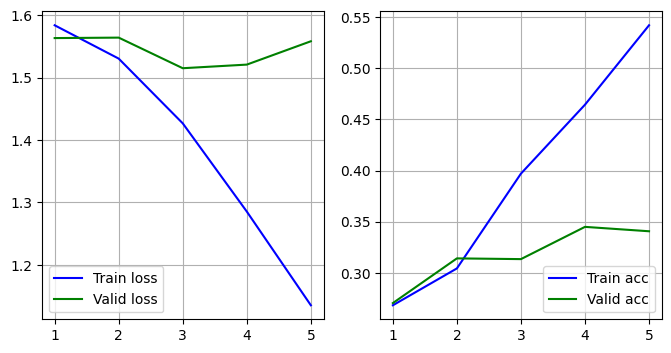

44/44 - 1s - loss: 1.5584 - accuracy: 0.3407 - 1s/epoch - 25ms/step

Test accuracy: 0.34073013067245483


In [17]:
input_shape = X_train.shape[1:]
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(16, (5, 5), activation='relu', input_shape=input_shape),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5),  # Dodanie warstwy dropout
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(len(labels_encoder.classes_), activation='softmax')
])

# Skompiluj model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Wytrenuj model
history = model.fit(X_train, y_train, epochs=5, validation_data=(X_test, y_test), batch_size=32)

plotPrint(history)

# Ocena modelu na danych testowych
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
print(f'\nTest accuracy: {test_acc}')

In [25]:

input_shape = X_train.shape[1:]
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (7, 7), activation='relu', input_shape=input_shape),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (5, 5), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.2),  # Dodanie warstwy dropout
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(len(label_encoder.classes_), activation='softmax')
])

# Skompiluj model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Tworzenie instancji ImageDataGenerator do augmentacji danych treningowych
train_datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='constant',
    cval=0.5
)

# Ustawienie generatora dla danych treningowych
train_generator = train_datagen.flow(X_train, y_train, batch_size=32)

# Ustawienie callbacku do zapisywania modelu
checkpoint = tf.keras.callbacks.ModelCheckpoint(f'{modelsDir}model.h5', save_best_only=True)

# Trenowanie modelu z użyciem generatora
history = model.fit_generator(
    train_generator,
    steps_per_epoch=len(X_train)//32,  # Liczba kroków na epokę (długość danych treningowych / batch_size)
    epochs=15,
    validation_data=(X_test, y_test),
    callbacks=[checkpoint]
)


plotPrint(history)

# Ocena modelu na danych testowych
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
print(f'\nTest accuracy: {test_acc}')

NameError: name 'label_encoder' is not defined

#### Confusion Matrix
Precision, Recall and F1 score

44/44 [==============================] - 6s 126ms/step


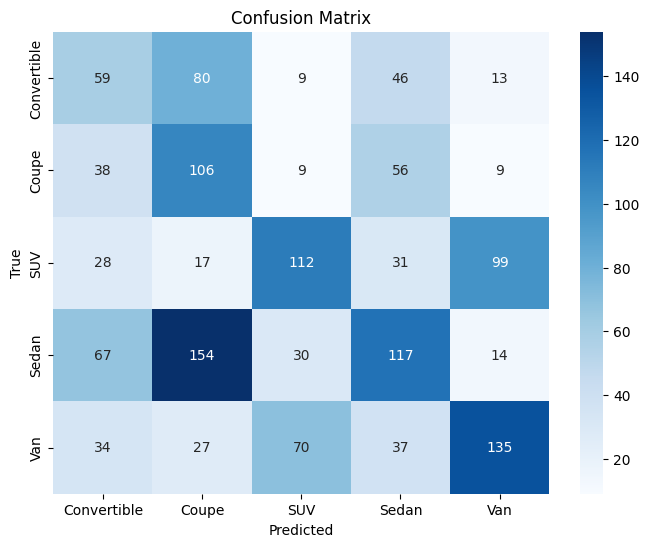

In [85]:
# Predicted labels for test data
predicted_labels = np.argmax(model.predict(X_test), axis=-1)

cm = confusion_matrix(y_test, predicted_labels)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=labels_encoder.classes_, yticklabels=labels_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [86]:
precision = precision_score(y_test, predicted_labels, average='weighted')
recall = recall_score(y_test, predicted_labels, average='weighted')
f1 = f1_score(y_test, predicted_labels, average='weighted')

print(f'Precision: {precision}')
print(f'Recal: {recall}')
print(f'F1 Score: {f1}')

Precision: 0.4017191489461911
Recal: 0.3786685755189692
F1 Score: 0.3821898575028648


In [87]:
# generateFromOriginalImages('128x128',(128,128))
saveModel(model=model, model_name='mapotencial')

Model został zapisany pod nazwą: mapotencial


['Convertible' 'Coupe' 'SUV' 'Sedan' 'Van']
{0: 1.3471652593486128, 1: 1.2836781609195402, 2: 0.9711304347826087, 3: 0.732327868852459, 4: 0.9229752066115703}
Model: "model_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_26 (InputLayer)       [(None, 128, 128, 1)]     0         
                                                                 
 conv2d_69 (Conv2D)          (None, 122, 122, 64)      3200      
                                                                 
 max_pooling2d_59 (MaxPoolin  (None, 61, 61, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_70 (Conv2D)          (None, 57, 57, 64)        102464    
                                                                 
 max_pooling2d_60 (MaxPoolin  (None, 28, 28, 64)       0         
 g2D)                          

C:\Users\Cezary\AppData\Local\Temp\ipykernel_6368\2865441430.py:62: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


349/349 [==============================] - 102s 287ms/step - loss: 1.6108 - accuracy: 0.1725 - val_loss: 1.6090 - val_accuracy: 0.2054
Epoch 2/5
349/349 [==============================] - 101s 289ms/step - loss: 1.6101 - accuracy: 0.2144 - val_loss: 1.6163 - val_accuracy: 0.1560
Epoch 3/5
349/349 [==============================] - 101s 290ms/step - loss: 1.6032 - accuracy: 0.2011 - val_loss: 1.5803 - val_accuracy: 0.2419
Epoch 4/5
349/349 [==============================] - 103s 294ms/step - loss: 1.5891 - accuracy: 0.2357 - val_loss: 1.5658 - val_accuracy: 0.2520
Epoch 5/5
349/349 [==============================] - 102s 293ms/step - loss: 1.5737 - accuracy: 0.2523 - val_loss: 1.5402 - val_accuracy: 0.2606


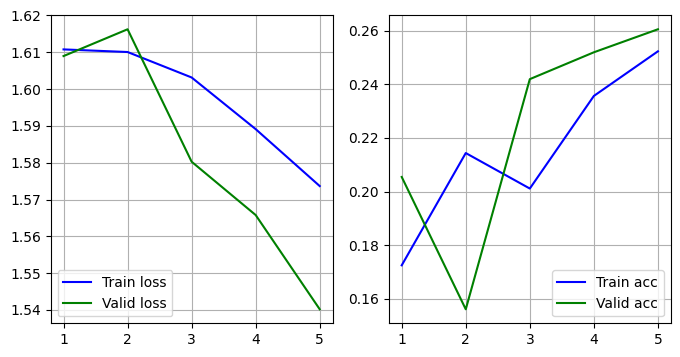

44/44 - 5s - loss: 1.5402 - accuracy: 0.2606 - 5s/epoch - 115ms/step

Test accuracy: 0.2605583369731903


In [77]:
input_shape = X_train.shape[1:]
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)

# Konwersja wag klas na słownik
class_weight_dict = dict(enumerate(class_weights))
print(labels_encoder.classes_)
print(class_weight_dict)

input_layer = Input(shape=input_shape)

# Warstwa konwolucyjna 1
conv1 = Conv2D(64, (7, 7), activation='relu')(input_layer)
max_pool1 = MaxPooling2D((2, 2))(conv1)

# Warstwa konwolucyjna 2
conv2 = Conv2D(64, (5, 5), activation='relu')(max_pool1)
max_pool2 = MaxPooling2D((2, 2))(conv2)

conv3 = Conv2D(64, (3, 3), activation='relu')(max_pool2)
max_pool3 = MaxPooling2D((2, 2))(conv3)

# Warstwa spłaszczająca
flatten = Flatten()(max_pool3)

# Warstwa dropout
dropout = Dropout(0.2)(flatten)

# Warstwa gęsta 1
dense1 = Dense(64, activation='relu')(dropout)

# Warstwa wyjściowa
output_layer = Dense(len(labels_encoder.classes_), activation='softmax')(dense1)

# Tworzenie modelu
model = Model(inputs=input_layer, outputs=output_layer)
print(model.summary())

# Skompiluj model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Tworzenie instancji ImageDataGenerator do augmentacji danych treningowych
train_datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='constant',
    cval=0.5
)

# Ustawienie generatora dla danych treningowych
train_generator = train_datagen.flow(X_train, y_train, batch_size=16)

# Ustawienie callbacku do zapisywania modelu
# checkpoint = tf.keras.callbacks.ModelCheckpoint(f'{modelsDir}model.h5', save_best_only=True)

# Trenowanie modelu z użyciem generatora
history = model.fit_generator(
    train_generator,
    steps_per_epoch=len(X_train)//16,
    epochs=5,
    validation_data=(X_test, y_test),
    # callbacks=[checkpoint],
    class_weight=class_weight_dict
)

# Wyświetlenie wyników
plotPrint(history)

# Ocena modelu na danych testowych
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
print(f'\nTest accuracy: {test_acc}')

Epoch 1/5


C:\Users\Cezary\AppData\Local\Temp\ipykernel_6368\3571616332.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


349/349 [==============================] - 109s 313ms/step - loss: 1.4351 - accuracy: 0.3356 - val_loss: 1.4232 - val_accuracy: 0.3278
Epoch 2/5
349/349 [==============================] - 114s 325ms/step - loss: 1.4144 - accuracy: 0.3424 - val_loss: 1.3752 - val_accuracy: 0.3694
Epoch 3/5
349/349 [==============================] - 112s 321ms/step - loss: 1.3964 - accuracy: 0.3515 - val_loss: 1.3601 - val_accuracy: 0.3744
Epoch 4/5
349/349 [==============================] - 112s 322ms/step - loss: 1.3686 - accuracy: 0.3657 - val_loss: 1.4031 - val_accuracy: 0.3658
Epoch 5/5
349/349 [==============================] - 114s 327ms/step - loss: 1.3488 - accuracy: 0.3845 - val_loss: 1.3341 - val_accuracy: 0.3787


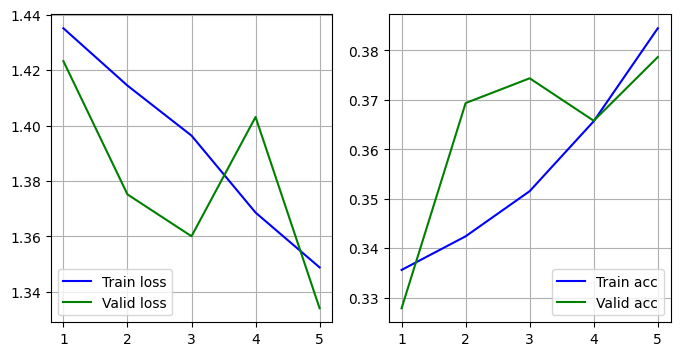

44/44 - 6s - loss: 1.3341 - accuracy: 0.3787 - 6s/epoch - 126ms/step

Test accuracy: 0.37866857647895813


In [79]:
history = model.fit_generator(
    train_generator,
    steps_per_epoch=len(X_train)//16,
    epochs=5,
    validation_data=(X_test, y_test),
    # callbacks=[checkpoint],
    class_weight=class_weight_dict
)

# Wyświetlenie wyników
plotPrint(history)

# Ocena modelu na danych testowych
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
print(f'\nTest accuracy: {test_acc}')

In [40]:

# Obliczenie wag klas na podstawie liczności klas
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
print(class_weights)
# Konwersja wag klas na słownik
class_weight_dict = dict(enumerate(class_weights))
print(class_weight_dict)
# Definicja wejścia
input_layer = Input(shape=input_shape)

# Pierwsza ścieżka konwolucyjna
conv1a = Conv2D(32, (5, 5), activation='relu', padding='same')(input_layer)
conv1b = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1a)
max_pool1 = MaxPooling2D((2, 2))(conv1b)

# Druga ścieżka konwolucyjna
conv2a = Conv2D(64, (7, 7), activation='relu', padding='same')(input_layer)
conv2b = Conv2D(32, (5, 5), activation='relu', padding='same')(conv2a)
max_pool2 = MaxPooling2D((2, 2))(conv2b)

# Połączenie wyników z obu ścieżek
concatenated = concatenate([max_pool1, max_pool2])

# Warstwa spłaszczająca
flatten = Flatten()(concatenated)

# Warstwa dropout
dropout = Dropout(0.3)(flatten)

# Warstwa gęsta
dense = Dense(64, activation='relu')(dropout)

# Warstwa wyjściowa
output_layer = Dense(len(labels_encoder.classes_), activation='softmax')(dense)

# Tworzenie modelu
model = Model(inputs=input_layer, outputs=output_layer)

# Skompiluj model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Tworzenie instancji ImageDataGenerator do augmentacji danych treningowych
train_datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='constant',
    cval=0.5
)

# Ustawienie generatora dla danych treningowych
train_generator = train_datagen.flow(X_train, y_train, batch_size=32)

# Ustawienie callbacku do zapisywania modelu
checkpoint = tf.keras.callbacks.ModelCheckpoint(f'{modelsDir}model.h5', save_best_only=True)

# Trenowanie modelu z użyciem generatora
history = model.fit_generator(
    train_generator,
    steps_per_epoch=len(X_train)//32,
    epochs=15,
    validation_data=(X_test, y_test),
    callbacks=[checkpoint],
    class_weight=class_weight_dict
)

# Wyświetlenie wyników
plotPrint(history)

# Ocena modelu na danych testowych
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
print(f'\nTest accuracy: {test_acc}')

[1.34716526 1.28367816 0.97113043 0.73232787 0.92297521]
{0: 1.3471652593486128, 1: 1.2836781609195402, 2: 0.9711304347826087, 3: 0.732327868852459, 4: 0.9229752066115703}
Epoch 1/15


C:\Users\Cezary\AppData\Local\Temp\ipykernel_6368\2964150352.py:62: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


174/174 [==============================] - 345s 2s/step - loss: 1.7887 - accuracy: 0.1945 - val_loss: 1.6096 - val_accuracy: 0.2169
Epoch 2/15
174/174 [==============================] - 345s 2s/step - loss: 1.6095 - accuracy: 0.1623 - val_loss: 1.6095 - val_accuracy: 0.2169
Epoch 3/15
174/174 [==============================] - 345s 2s/step - loss: 1.6100 - accuracy: 0.1843 - val_loss: 1.6097 - val_accuracy: 0.2069
Epoch 4/15
 89/174 [==============>...............] - ETA: 2:34 - loss: 1.6152 - accuracy: 0.1643

KeyboardInterrupt: 

In [8]:

np.set_printoptions(edgeitems=10)

X_train, X_test, y_train, y_test = train_test_split(imagesProc, labels, test_size=0.2, stratify=labels)
X_train = X_train.reshape(X_train.shape + (1,))
X_test = X_test.reshape(X_test.shape + (1,))


# Stworzenie kopii etykiet
labels_general = np.array(y_train.copy())
labels_small = np.array(y_train.copy())
labels_big = np.array(y_train.copy())

labels_general_test = np.array(y_test.copy())
labels_small_test = np.array(y_test.copy())
labels_big_test = np.array(y_test.copy())

# Zamiana określonych etykiet na 'small'
labels_general[np.isin(labels_general, ['Coupe', 'Sedan', 'Convertible'])] = 'small'

# Zamiana pozostałych etykiet na 'big'
labels_general[np.isin(labels_general, ['SUV', 'Van'])] = 'big'

labels_small[np.isin(labels_general, ['big'])] = None
labels_big[np.isin(labels_general, ['small'])] = None

labels_general_test[np.isin(labels_general_test, ['Coupe', 'Sedan', 'Convertible'])] = 'small'

# Zamiana pozostałych etykiet na 'big'
labels_general_test[np.isin(labels_general_test, ['SUV', 'Van'])] = 'big'

labels_small_test[np.isin(labels_general_test, ['big'])] = None
labels_big_test[np.isin(labels_general_test, ['small'])] = None

# Wydrukowanie oryginalnych i zmienionych etykiet
print("Oryginalne etykiety:")
print(labels)

print("\nZmienione labels_general:")
print(labels_general)

print("\nZmienione labels_small:")
print(labels_small)

print("\nZmienione labels_big:")
print(labels_big)

labels_encoded_small, labels_encoder_small = encodeLabel(labels_small)
y_labels_small = to_categorical(labels_encoded_small, num_classes=4)

labels_encoded_small_test = labels_encoder_small.transform(labels_small_test)
y_labels_small_test = to_categorical(labels_encoded_small_test, num_classes=4)


labels_encoded_big, labels_encoder_big = encodeLabel(labels_big)
y_labels_big = to_categorical(labels_encoded_big, num_classes=3)

labels_encoded_big_test = labels_encoder_big.transform(labels_big_test)
y_labels_big_test = to_categorical(labels_encoded_big_test, num_classes=3)


labels_encoded_general, labels_encoder_general = encodeLabel(labels_general)
y_labels_general = to_categorical(labels_encoded_general, num_classes=2)

labels_encoded_general_test = labels_encoder_general.transform(labels_general_test)
y_labels_general_test = to_categorical(labels_encoded_general_test, num_classes=2)


labels_encoded_finale, labels_encoder_finale = encodeLabel(y_train)
y_labels_finale = to_categorical(labels_encoded_finale, num_classes=5)

labels_encoded_finale_test = labels_encoder_finale.transform(y_test)
y_labels_finale_test = to_categorical(labels_encoded_finale_test, num_classes=5)

print(f'len: {len(y_labels_small)} {len(y_labels_general)} {len(y_labels_big)} {len(labels_encoded_finale)} ')

print(y_train)
print(y_labels_finale)
print(y_test)
print(y_labels_finale_test)

Oryginalne etykiety:
['Coupe', 'Sedan', 'Van', 'Sedan', 'Van', 'Convertible', 'SUV', 'Sedan', 'Sedan', 'SUV', 'Sedan', 'SUV', 'Sedan', 'Van', 'Coupe', 'Coupe', 'Sedan', 'Convertible', 'SUV', 'Sedan', 'Sedan', 'Sedan', 'Van', 'Coupe', 'Sedan', 'SUV', 'SUV', 'SUV', 'Coupe', 'Convertible', 'Sedan', 'SUV', 'Coupe', 'Van', 'Convertible', 'SUV', 'Coupe', 'Sedan', 'Sedan', 'Sedan', 'Coupe', 'Van', 'SUV', 'Coupe', 'Coupe', 'Van', 'Sedan', 'Van', 'Van', 'Van', 'Van', 'Coupe', 'Sedan', 'Convertible', 'Sedan', 'Van', 'Sedan', 'Sedan', 'Van', 'SUV', 'Van', 'Van', 'Sedan', 'Convertible', 'SUV', 'Coupe', 'SUV', 'Convertible', 'Van', 'Van', 'Sedan', 'SUV', 'Sedan', 'Sedan', 'Van', 'Sedan', 'Sedan', 'Convertible', 'Coupe', 'Van', 'Coupe', 'Sedan', 'SUV', 'Van', 'Sedan', 'Sedan', 'Van', 'SUV', 'Sedan', 'SUV', 'Van', 'SUV', 'Coupe', 'Coupe', 'Sedan', 'SUV', 'Van', 'Van', 'SUV', 'Coupe', 'Sedan', 'SUV', 'Convertible', 'SUV', 'Coupe', 'Van', 'Sedan', 'Coupe', 'Sedan', 'SUV', 'Coupe', 'SUV', 'Sedan', 'Conv

(5584, 2)
(5584, 4)
(5584, 3)
(5584, 5)
Epoch 1/5
349/349 [==============================] - 146s 410ms/step - loss: 4.5542 - output_general_loss: 0.6594 - output_specific_small_loss: 1.2962 - output_specific_large_loss: 1.0094 - output_final_loss: 1.5892 - output_general_accuracy: 0.6207 - output_specific_small_accuracy: 0.4237 - output_specific_large_accuracy: 0.5777 - output_final_accuracy: 0.2887 - val_loss: 4.3123 - val_output_general_loss: 0.6106 - val_output_specific_small_loss: 1.2560 - val_output_specific_large_loss: 0.9260 - val_output_final_loss: 1.5197 - val_output_general_accuracy: 0.6729 - val_output_specific_small_accuracy: 0.4338 - val_output_specific_large_accuracy: 0.5791 - val_output_final_accuracy: 0.3214
Epoch 2/5
349/349 [==============================] - 140s 402ms/step - loss: 4.0724 - output_general_loss: 0.5593 - output_specific_small_loss: 1.1881 - output_specific_large_loss: 0.8921 - output_final_loss: 1.4329 - output_general_accuracy: 0.7213 - output_specif

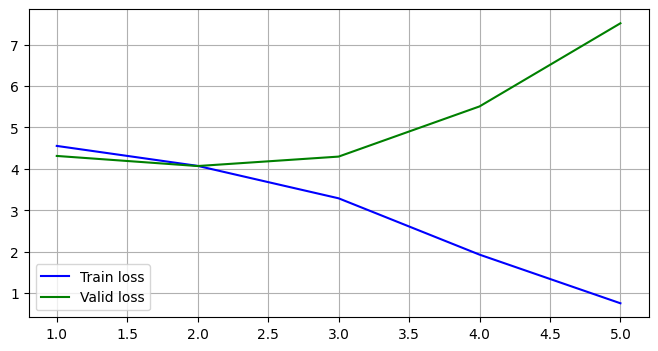

ValueError: Failed to find data adapter that can handle input: <class 'numpy.ndarray'>, (<class 'list'> containing values of types {"<class 'str'>"})

In [31]:

input_shape = X_train.shape[1:]
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)

# Konwersja wag klas na słownik
class_weight_dict = dict(enumerate(class_weights))

# Definicja wejścia
input_layer = Input(shape=input_shape)

# Pierwsza warstwa konwolucyjna dla ogólnego poziomu (samochody małe/duże)
conv_general1 = Conv2D(32, (3, 3), activation='relu', padding='same')(input_layer)
max_pool_general1 = MaxPooling2D((2, 2))(conv_general1)

# Druga warstwa konwolucyjna dla ogólnego poziomu
conv_general2 = Conv2D(64, (3, 3), activation='relu', padding='same')(max_pool_general1)
max_pool_general2 = MaxPooling2D((2, 2))(conv_general2)

# Warstwa spłaszczająca
flatten_general = Flatten()(max_pool_general2)

# Warstwa gęsta dla ogólnego poziomu
dense_general = Dense(128, activation='relu')(flatten_general)

# Warstwa wyjściowa dla ogólnego poziomu
output_general = Dense(2, activation='softmax', name='output_general')(dense_general)

# Pierwsza warstwa konwolucyjna dla szczegółowego poziomu (samochody małe)
conv_specific1_small = Conv2D(32, (3, 3), activation='relu', padding='same')(input_layer)
max_pool_specific1_small = MaxPooling2D((2, 2))(conv_specific1_small)

# Druga warstwa konwolucyjna dla szczegółowego poziomu
conv_specific2_small = Conv2D(64, (3, 3), activation='relu', padding='same')(max_pool_specific1_small)
max_pool_specific2_small = MaxPooling2D((2, 2))(conv_specific2_small)

# Warstwa spłaszczająca
flatten_specific_small = Flatten()(max_pool_specific2_small)

# Warstwa gęsta dla szczegółowego poziomu
dense_specific_small = Dense(128, activation='relu')(flatten_specific_small)

# Warstwa wyjściowa dla szczegółowego poziomu (samochody małe)
output_specific_small = Dense(4, activation='softmax', name='output_specific_small')(dense_specific_small)

# Pierwsza warstwa konwolucyjna dla szczegółowego poziomu (samochody duże)
conv_specific1_large = Conv2D(32, (3, 3), activation='relu', padding='same')(input_layer)
max_pool_specific1_large = MaxPooling2D((2, 2))(conv_specific1_large)

# Druga warstwa konwolucyjna dla szczegółowego poziomu
conv_specific2_large = Conv2D(64, (3, 3), activation='relu', padding='same')(max_pool_specific1_large)
max_pool_specific2_large = MaxPooling2D((2, 2))(conv_specific2_large)

# Warstwa spłaszczająca
flatten_specific_large = Flatten()(max_pool_specific2_large)

# Warstwa gęsta dla szczegółowego poziomu
dense_specific_large = Dense(128, activation='relu')(flatten_specific_large)

# Warstwa wyjściowa dla szczegółowego poziomu (samochody duże)
output_specific_large = Dense(3, activation='softmax', name='output_specific_large')(dense_specific_large)

# Połączenie obu wyjść
merged = concatenate([dense_general, dense_specific_small, dense_specific_large])

# Warstwa gęsta dla końcowego wyjścia
final_dense = Dense(256, activation='relu')(merged)

# Warstwa wyjściowa końcowa
output_layer = Dense(5, activation='softmax', name='output_final')(final_dense)

# Model dla samochodów
model_cars = Model(inputs=input_layer, outputs=[output_general, output_specific_small, output_specific_large, output_layer])

# Skompiluj model z odpowiednimi funkcjami straty dla każdej kategorii
model_cars.compile(optimizer='adam',
                    loss={'output_general': 'categorical_crossentropy',
                          'output_specific_small': 'categorical_crossentropy',
                          'output_specific_large': 'categorical_crossentropy',
                          'output_final': 'categorical_crossentropy'},
                    metrics=['accuracy'])


train_datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='constant',
    cval=0.5
)
print(y_labels_general.shape)
print(y_labels_small.shape)
print(y_labels_big.shape)
print(y_labels_finale.shape)
# Ustawienie generatora dla danych treningowych
# train_generator = train_datagen.flow(X_train,
#                                        {'output_general': y_labels_general, 'output_specific_small': y_labels_small, 'output_specific_large': y_labels_big, 'output_final': y_labels_finale},
#                                         batch_size=16,class_mode='multi_output',)


# # Trenowanie modelu z użyciem generatora
# history = model_cars.fit_generator(
#     train_generator,
#     steps_per_epoch=len(X_train)//16,
#     epochs=1,
#     validation_data=(X_test, y_test),
#     class_weight=class_weight_dict
# )

history = model_cars.fit(
    X_train,
    {'output_general': y_labels_general, 'output_specific_small': y_labels_small, 'output_specific_large': y_labels_big, 'output_final': y_labels_finale},
    epochs=5,
    validation_data=(X_test, {'output_general': y_labels_general_test, 'output_specific_small': y_labels_small_test, 'output_specific_large': y_labels_big_test, 'output_final': y_labels_finale_test}),
    # class_weight=class_weight_dict,
    batch_size=16
)

# Wyświetlenie wyników
plotPrint(history)

# # Ocena modelu na danych testowych
# test_loss, test_acc = model_cars.evaluate(X_test, y_test, verbose=2)
# print(f'\nTest accuracy: {test_acc}')

44/44 [==============================] - 5s 114ms/step


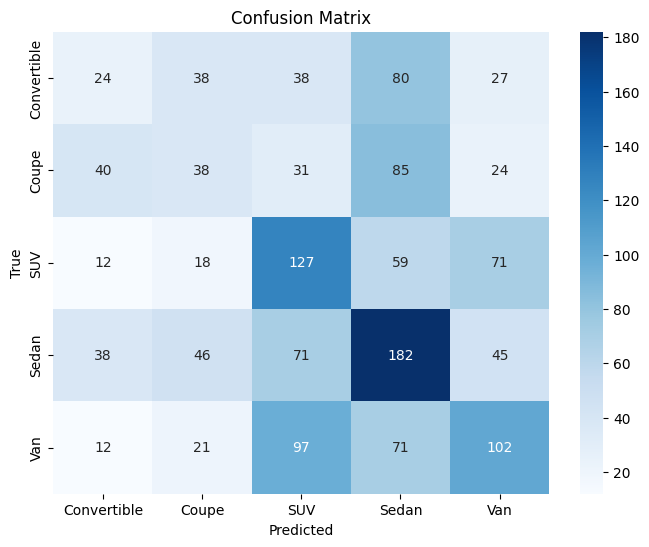

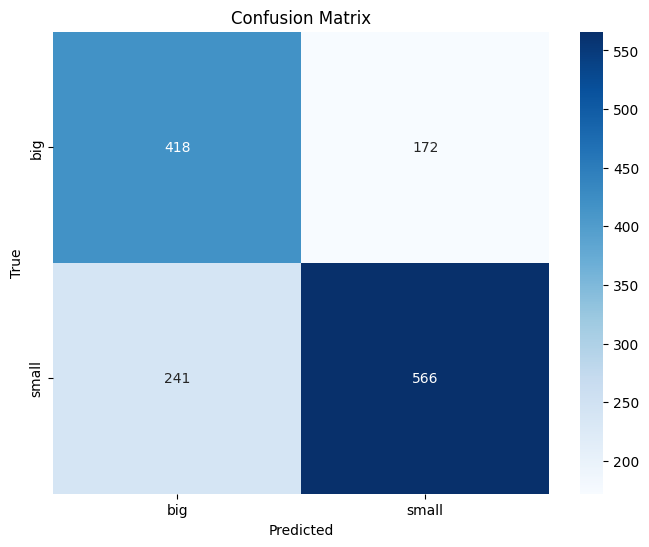

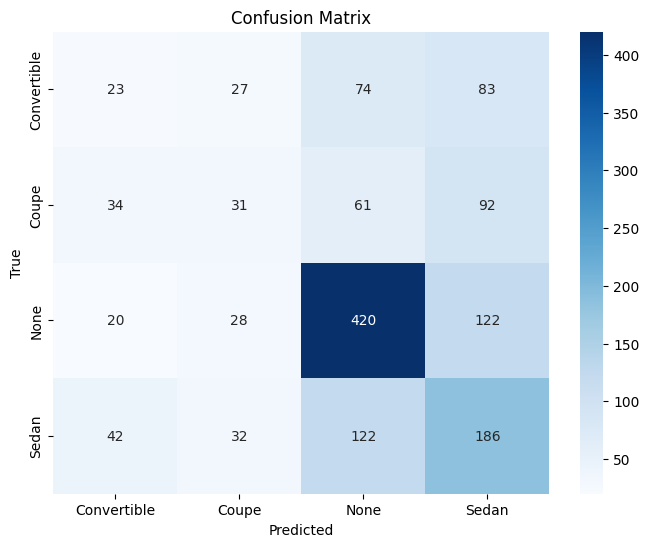

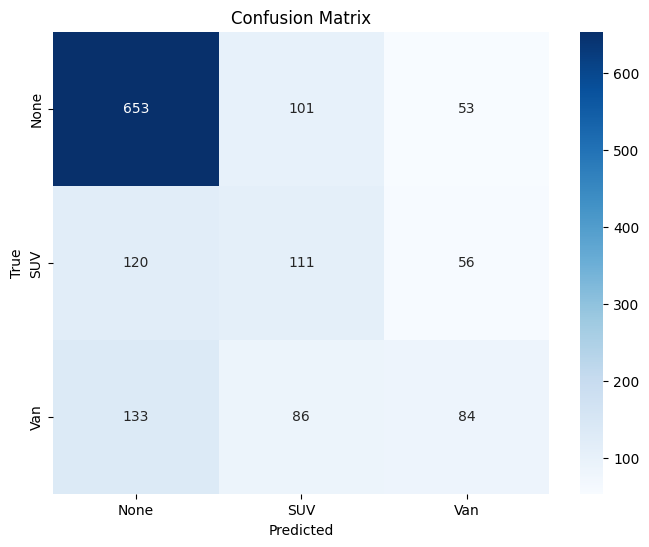

In [32]:
# Predicted labels for test data
predict = model_cars.predict(X_test)

predicted_labels = np.argmax(predict[3], axis=-1)

cm = confusion_matrix(labels_encoded_finale_test, predicted_labels)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=labels_encoder.classes_, yticklabels=labels_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

predicted_labels = np.argmax(predict[0], axis=-1)

cm = confusion_matrix(labels_encoded_general_test, predicted_labels)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=labels_encoder_general.classes_, yticklabels=labels_encoder_general.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


predicted_labels = np.argmax(predict[1], axis=-1)

cm = confusion_matrix(labels_encoded_small_test, predicted_labels)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=labels_encoder_small.classes_, yticklabels=labels_encoder_small.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


predicted_labels = np.argmax(predict[2], axis=-1)

cm = confusion_matrix(labels_encoded_big_test, predicted_labels)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=labels_encoder_big.classes_, yticklabels=labels_encoder_big.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()
